In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# create a profile
dx = 500
x = np.arange(0, 50000, dx)
x_node = x + (dx/2)

# add some elevation
Hstar = 0.5 # depth decay
etab = np.zeros(len(x)) # bedrock elevation
etab[:] = np.linspace(1, 0.1, len(x)) # need to start with slight bedrock slope
H = Hstar + np.zeros(len(x)) # alluvium thickness
eta = etab + H # topography

In [3]:
# define constants and other parameters
K = 1e-6 # erodibility
beta = 0.0005 # abradability
r = 10. # runoff rate
U = 0.0001 # uplift or baselevel fall rate
I = 0.03 # intermittency
phi = 0.1 # porosity
D = 0.01 # grain size

kqs = 0.041 # sed transport coeff
kxb = 25 # valley width coeff
Pxb = 1./5. # valley width exp
kb = 8.3e-8 # channel width coeff

B_valley = kxb * (x_node**Pxb) # valley width
Q = (r * kxb * x_node**(1 + Pxb))/(1 + Pxb) # discharge

In [4]:
def model(x, dx, x_node,
          K, beta,
          D, phi, Hstar,
          kb, kqs, I, r, U,
          etab, H, eta,
          B_valley, Q,
          num_steps = 1):
    
    q = Q/B_valley
    dt = 500
    
    run_duration = dt * num_steps
    cum_time = 0.0
    
    Qs = np.zeros(len(x))
    qs = np.zeros(len(x))
    Eb_p = np.zeros(len(x))
    Eb_a = np.zeros(len(x))
    Eb = np.zeros(len(x))
    Eh = np.zeros(len(x))
    E = np.zeros(len(x))
    
    H[-1] = 0
    E[-1] = U
    q[0] = 0
    Qs[0] = 0
    
    while cum_time < run_duration:
        
        # drop baselevel
        eta[-1] -= U * dt
        
        # set boundary conditions
        etab[-1] = eta[-1]
        
        # calc slope
        S = -np.diff(eta)/dx
        
        # calc bed exposure
        alpha = np.exp(-H/Hstar)
        
        # calc sed transport
        Qs[1:] = kqs * I * Q[1:] * S**(7./6.) * (1 - alpha[:-1])
        qs[1:] = Qs[1:] / B_valley[1:]
        
        # calc bedrock erosion
        Eb_p[:-1] = K * Q[1:] * S**(7./6.) * alpha[:-1]
        Eb_a[:-1] = beta * Qs[1:] * alpha[:-1]
        Eb[:-1] = (Eb_p[:-1] + Eb_a[:-1]) / B_valley[:-1]
        
        # calc grain attrition
        atr = Qs * beta
        
        # calc sediment erosion rate
        Eh[:-1] = 1/((1 - phi) * B_valley[:-1]) * (np.diff(Qs)/dx + atr[1:] - Eb_p[:-1])
        
        # calc total erosion rate
        E[:-1] = Eb[:-1] + Eh[:-1]
        
        # update topography
        etab[:-1] -= Eb[:-1] * dt
        H[:-1] -= Eh[:-1] * dt
        H[H<0] = 0
        eta[:-1] = etab[:-1] + H[:-1]
        
        # update elapsed time
        cum_time += dt
        
    print(cum_time)
        
    return (dt, S, q, alpha, Qs, qs, Eb_p, Eb_a, Eb, atr, Eh, E, etab, H, eta)

In [5]:
#now write a test
num_steps = 40000
test_run = [x, dx, x_node, 
            K, beta, 
            D, phi, Hstar,
            kb, kqs, I, r, U,
            etab, H, eta,
            B_valley, Q,
            num_steps]

# and run it
(dt, S, q, alpha, Qs, qs, Eb_p, Eb_a, Eb, atr, Eh, E, etab, H, eta) = model(*test_run)

20000000.0


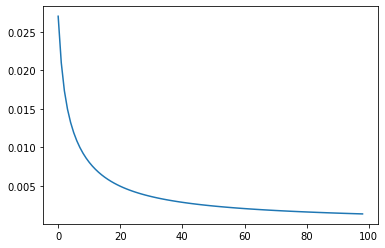

In [6]:
plt.plot(S)

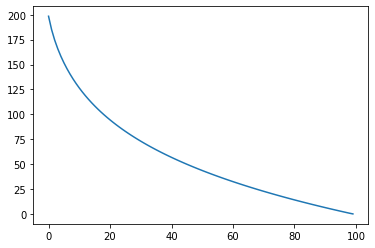

In [7]:
# adjust baselevel
eta_adj = eta - eta[-1]

plt.plot(eta_adj)

In [8]:
# okay, so far looks good... now try comparing to ben's analytical solution
A1 = beta * kqs * I
A2 = (1 - np.exp(-beta * x)) * K
A3 = beta * kqs * I

alpha_Ben = A1 / (A2 + A3)

term_1 = 1 - np.exp(-beta * x)
term_2 = K * Q * alpha_Ben
term_3 = term_1 * term_2 + K * Q
term_4 = (U * B_valley) / alpha_Ben

S_an_Ben = (term_4 / term_3) ** (6 / 7)

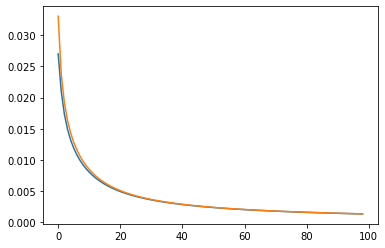

In [9]:
plt.plot(S)
plt.plot(S_an_Ben[1:])

In [10]:
# and what if we make a line using Ben's solution?
eta_an_Ben = np.cumsum(S_an_Ben * dx)

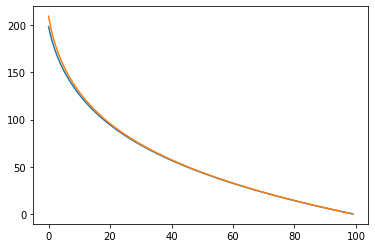

In [11]:
plt.plot(eta_adj)
plt.plot(-(eta_an_Ben - eta_an_Ben[-1]))